In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor


# 警告文を非表示に
import warnings
warnings.filterwarnings('ignore')
#カラム内の文字数。デフォルトは50だった
pd.set_option("display.max_colwidth", 100)
#行数
pd.set_option("display.max_rows", 500)
#列数
pd.set_option("display.max_columns", 500)

In [2]:
# データのインポート
Data2013 = pd.read_excel("Data2013.xlsx")
Data2016 = pd.read_excel("Data2016.xlsx")
Data2019 = pd.read_excel("Data2019.xlsx")

# 2013年　前処理

## 新たな変数を追加する

### 情勢報道（朝日・読売・日経）

In [3]:
news2013 = pd.read_excel("news2013.xlsx")
news2013 = news2013[["candidate_J", "3news_avg", "asahi", "nikkei", "yomiuri"]]
Data2013 = pd.merge(Data2013, news2013, on='candidate_J', how='left')

### scandal ダミー

In [4]:
# 現職候補者に関しては、任期中に不祥事を起こしたら1、起こしてなかったら0を入れる
# wikipediaで確認する

scandal2013 = pd.read_excel("scandal2013.xlsx")
scandal2013.columns

Data2013 = pd.merge(Data2013, scandal2013, on='candidate_J', how='left')
Data2013 = Data2013.drop(["district_y", "incumbent_y"], axis=1)
Data2013 = Data2013.rename(columns={"district_x": "district", "incumbent_x": "incumbent"})

### 所属政党ダミー＊地方議会所属政党比率

In [5]:
# 地方議会の政党議席率を選挙区ごとに整理したデータセットを用意する
# http://www.soumu.go.jp/senkyo/senkyo_s/data/syozoku/ichiran.html
local2013 = pd.read_excel("local2013.xlsx")
local2013.columns

# カラム名を変える
local2013 = local2013.rename(columns={"district_code": "district_code", "district": "district", 
                             "ldp": "local_ldp", "ldp_rate": "local_ldp_rate", 
                             "dpj": "local_dpj", "dpj_rate": "local_dpj_rate",
                             "kyosan": "local_jcp", "kyosan_rate": "local_jcp_rate",
                             "komei": "local_kom", "komei_rate": "local_kom_rate",
                             "shamin": "local_syamin", "shamin_rate": "local_syamin_rate",
                             "ishin": "local_ishin", "ishin_rate": "local_ishin_rate"        })

# 使うカラムを選ぶ
local2013 = local2013[["district", "local_ldp_rate", "local_dpj_rate", "local_jcp_rate", "local_kom_rate",
                       "local_syamin_rate", "local_ishin_rate"]]

# データセットをmergeする
Data2013 = pd.merge(Data2013, local2013, on='district', how='left')

# 選挙区の政党議席率と候補者の所属政党を掛け合わせる
# イメージとしては、選挙区で優勢な政党であるほどこのカラムの値は大きくなる
# 例：候補者の所属政党が自民党の場合、当選に有利なはずだが選挙区で自民党が優勢かどうかでその有利さは変わるはず
Data2013["ldp_local_rate"] = Data2013["ldp"]*Data2013["local_ldp_rate"]
Data2013["dpj_local_rate"] = Data2013["dpj"]*Data2013["local_dpj_rate"]
Data2013["jcp_local_rate"] = Data2013["jcp"]*Data2013["local_jcp_rate"]
Data2013["kom_local_rate"] = Data2013["kom"]*Data2013["local_kom_rate"]
Data2013["syamin_local_rate"] = Data2013["syamin"]*Data2013["local_syamin_rate"]
Data2013["ishin_local_rate"] = Data2013["ishin"]*Data2013["local_ishin_rate"]
Data2013["party_local_advantage"] = Data2013["ldp_local_rate"]+Data2013["dpj_local_rate"]+Data2013["jcp_local_rate"]+Data2013["kom_local_rate"]+Data2013["syamin_local_rate"]+Data2013["ishin_local_rate"] 

### 所属政党ダミー＊衆院選所属政党比率

In [6]:
HR2013 = pd.read_excel("HR_12_VS.xlsx", index=False)
HR2013.columns

# カラム名を変える
HR2013 = HR2013.rename(columns={ 
                             "ldp_vs": "HR_ldp_rate", "dpj_vs": "HR_dpj_rate", 
                             "komei_vs": "HR_kom_rate", "jcp_vs": "HR_jcp_rate",
                             "sdp_vs": "HR_syamin_rate", "ishin_vs": "HR_ishin_rate"})

# 使うカラムを選ぶ
HR2013 = HR2013[["district", "HR_ldp_rate", "HR_dpj_rate", "HR_kom_rate", 
                 "HR_jcp_rate", "HR_syamin_rate", "HR_ishin_rate"]]

# データセットをmergeする
Data2013 = pd.merge(Data2013, HR2013, on='district', how='left')

# 選挙区の政党議席率と候補者の所属政党を掛け合わせる
# イメージとしては、選挙区で優勢な政党であるほどこのカラムの値は大きくなる
# 例：候補者の所属政党が自民党の場合、当選に有利なはずだが選挙区で自民党が優勢かどうかでその有利さは変わるはず
Data2013["ldp_HR_rate"] = Data2013["ldp"]*Data2013["HR_ldp_rate"]
Data2013["dpj_HR_rate"] = Data2013["dpj"]*Data2013["HR_dpj_rate"]
Data2013["jcp_HR_rate"] = Data2013["jcp"]*Data2013["HR_jcp_rate"]
Data2013["kom_HR_rate"] = Data2013["kom"]*Data2013["HR_kom_rate"]
Data2013["syamin_HR_rate"] = Data2013["syamin"]*Data2013["HR_syamin_rate"]
Data2013["ishin_HR_rate"] = Data2013["ishin"]*Data2013["HR_ishin_rate"]
Data2013["party_HR_advantage"] = Data2013["ldp_HR_rate"]+Data2013["dpj_HR_rate"]+Data2013["jcp_HR_rate"]+Data2013["kom_HR_rate"]+Data2013["syamin_HR_rate"]+Data2013["ishin_HR_rate"] 


### 与党ダミー

In [7]:
Data2013["ruling"] = 1
Data2013["ruling"] = Data2013["ruling"].where((Data2013["ldp"] ==1)|(Data2013["kom"]==1), 0)

### 与党＊地方議会与党比率ダミー

In [8]:
Data2013["local_ruling_rate"] = Data2013["local_ldp_rate"] + Data2013["local_kom_rate"]
Data2013["ruling_local_rate"] = Data2013["ruling"]*Data2013["local_ruling_rate"]*0.01

### 与党＊沖縄ダミー

In [9]:
Data2013["okinawa"] = 1
Data2013["okinawa"] = Data2013["okinawa"].where((Data2013["district"] =="沖縄"), 0)
Data2013["ruling_okinawa"] = Data2013["ruling"]*Data2013["okinawa"]

### 与党＊天気ダミー

In [10]:
weather = pd.read_excel("weather.xlsx")
weather =pd.DataFrame(weather)
weather2013 = weather.T[["district", 2013]]
weather2013 = weather2013.rename(columns={2013: "weather"})

# データセットをmergeする
Data2013 = pd.merge(Data2013, weather2013, on='district', how='left')

Data2013["ruling_weather"] = Data2013["ruling"]*Data2013["weather"]
Data2013["one"] = 1
Data2013["ruling_weather"] = Data2013["one"].where(Data2013["ruling_weather"]>0, 0)

In [11]:
weather2013.to_csv("weathertemp.csv")

### 世襲ダミー

In [12]:
hereditary2013 = pd.read_excel("hereditary2013.xlsx")
hereditary2013 = hereditary2013.fillna(0)
hereditary2013 = hereditary2013[["candidate_J", "hereditary"]]
Data2013 = pd.merge(Data2013, hereditary2013, on='candidate_J', how='left')

In [13]:
Data2013.to_pickle("Data2013.pickle")

# 2016年　前処理

## 新たな変数を追加する

### 情勢報道（朝日・読売・日経）

In [14]:
news2016 = pd.read_excel("news2016.xlsx")
news2016 = news2016[["candidate_J", "3news_avg", "asahi", "nikkei", "yomiuri"]]
Data2016 = pd.merge(Data2016, news2016, on='candidate_J', how='left')

### scandal ダミー

In [15]:
# 現職候補者に関しては、任期中に不祥事を起こしたら1、起こしてなかったら0を入れる
# wikipediaで確認する

scandal2016 = pd.read_excel("scandal2016.xlsx")
scandal2016.columns

Data2016 = pd.merge(Data2016, scandal2016, on='candidate_J', how='left')
Data2016 = Data2016.drop(["district_y", "incumbent_y"], axis=1)
Data2016 = Data2016.rename(columns={"district_x": "district", "incumbent_x": "incumbent"})

### 所属政党ダミー＊地方議会所属政党比率

In [16]:
# 地方議会の政党議席率を選挙区ごとに整理したデータセットを用意する
# http://www.soumu.go.jp/senkyo/senkyo_s/data/syozoku/ichiran.html
local2016 = pd.read_excel("local2016.xlsx")
local2016.columns

# カラム名を変える
local2016 = local2016.rename(columns={"district_code": "district_code", "district": "district", 
                             "ldp": "local_ldp", "ldp_rate": "local_ldp_rate", 
                             "dpj": "local_dpj", "dpj_rate": "local_dpj_rate",
                             "kyosan": "local_jcp", "kyosan_rate": "local_jcp_rate",
                             "komei": "local_kom", "komei_rate": "local_kom_rate",
                             "shamin": "local_syamin", "shamin_rate": "local_syamin_rate",
                             "ishin": "local_ishin", "ishin_rate": "local_ishin_rate"        })

# 使うカラムを選ぶ
local2016 = local2016[["district", "local_ldp_rate", "local_dpj_rate", "local_jcp_rate", "local_kom_rate",
                       "local_syamin_rate", "local_ishin_rate"]]

# データセットをmergeする
Data2016 = pd.merge(Data2016, local2016, on='district', how='left')

# 選挙区の政党議席率と候補者の所属政党を掛け合わせる
# イメージとしては、選挙区で優勢な政党であるほどこのカラムの値は大きくなる
# 例：候補者の所属政党が自民党の場合、当選に有利なはずだが選挙区で自民党が優勢かどうかでその有利さは変わるはず
Data2016["ldp_local_rate"] = Data2016["ldp"]*Data2016["local_ldp_rate"]
Data2016["dpj_local_rate"] = Data2016["dpj"]*Data2016["local_dpj_rate"]
Data2016["jcp_local_rate"] = Data2016["jcp"]*Data2016["local_jcp_rate"]
Data2016["kom_local_rate"] = Data2016["kom"]*Data2016["local_kom_rate"]
Data2016["syamin_local_rate"] = Data2016["syamin"]*Data2016["local_syamin_rate"]
Data2016["ishin_local_rate"] = Data2016["ishin"]*Data2016["local_ishin_rate"]
Data2016["party_local_advantage"] = Data2016["ldp_local_rate"]+Data2016["dpj_local_rate"]+Data2016["jcp_local_rate"]+Data2016["kom_local_rate"]+Data2016["syamin_local_rate"]+Data2016["ishin_local_rate"] 

### 所属政党ダミー＊衆院選所属政党比率

In [17]:
HR2016 = pd.read_excel("HR_14_VS.xlsx", index=False)
HR2016.columns

# カラム名を変える
HR2016 = HR2016.rename(columns={ 
                             "ldp_vs": "HR_ldp_rate", "dpj_vs": "HR_dpj_rate", 
                             "komei_vs": "HR_kom_rate", "jcp_vs": "HR_jcp_rate",
                             "sdp_vs": "HR_syamin_rate", "ishin_vs": "HR_ishin_rate"})

# 使うカラムを選ぶ
HR2016 = HR2016[["district", "HR_ldp_rate", "HR_dpj_rate", "HR_kom_rate", 
                 "HR_jcp_rate", "HR_syamin_rate", "HR_ishin_rate"]]

# データセットをmergeする
Data2016 = pd.merge(Data2016, HR2016, on='district', how='left')

# 選挙区の政党議席率と候補者の所属政党を掛け合わせる
# イメージとしては、選挙区で優勢な政党であるほどこのカラムの値は大きくなる
# 例：候補者の所属政党が自民党の場合、当選に有利なはずだが選挙区で自民党が優勢かどうかでその有利さは変わるはず
Data2016["ldp_HR_rate"] = Data2016["ldp"]*Data2016["HR_ldp_rate"]
Data2016["dpj_HR_rate"] = Data2016["dpj"]*Data2016["HR_dpj_rate"]
Data2016["jcp_HR_rate"] = Data2016["jcp"]*Data2016["HR_jcp_rate"]
Data2016["kom_HR_rate"] = Data2016["kom"]*Data2016["HR_kom_rate"]
Data2016["syamin_HR_rate"] = Data2016["syamin"]*Data2016["HR_syamin_rate"]
Data2016["ishin_HR_rate"] = Data2016["ishin"]*Data2016["HR_ishin_rate"]
Data2016["party_HR_advantage"] = Data2016["ldp_HR_rate"]+Data2016["dpj_HR_rate"]+Data2016["jcp_HR_rate"]+Data2016["kom_HR_rate"]+Data2016["syamin_HR_rate"]+Data2016["ishin_HR_rate"] 


### 与党ダミー

In [18]:
Data2016["ruling"] = 1
Data2016["ruling"] = Data2016["ruling"].where((Data2016["ldp"] ==1)|(Data2016["kom"]==1), 0)

### 与党＊地方議会与党比率ダミー

In [19]:
Data2016["local_ruling_rate"] = Data2016["local_ldp_rate"] + Data2016["local_kom_rate"]
Data2016["ruling_local_rate"] = Data2016["ruling"]*Data2016["local_ruling_rate"]*0.01

### 与党＊衆議院与党比率ダミー

In [20]:
HR2016 = pd.read_excel("HR_14_VS.xlsx", index=False)
HR2016 = HR2016.rename({"komei_vs": "kom_vs"}, axis=1)
HR2016["ruling_vs"] = HR2016["ldp_vs"] + HR2016["kom_vs"]
HR2016 = HR2016[["district", "ruling_vs"]]

# データセットをmergeする
Data2016 = pd.merge(Data2016, HR2016, on='district', how='left')

Data2016["ruling_HR_vs"] = Data2016["ruling"]*Data2016["ruling_vs"]*0.01

### 与党＊沖縄ダミー

In [21]:
Data2016["okinawa"] = 1
Data2016["okinawa"] = Data2016["okinawa"].where((Data2016["district"] =="沖縄"), 0)
Data2016["ruling_okinawa"] = Data2016["ruling"]*Data2016["okinawa"]

### 世襲ダミー

In [22]:
hereditary2016 = pd.read_excel("hereditary2016.xlsx")
hereditary2016 = hereditary2016.fillna(0)
hereditary2016 = hereditary2016[["candidate_J", "hereditary"]]
Data2016 = pd.merge(Data2016, hereditary2016, on='candidate_J', how='left')

### 与党＊天気ダミー

In [23]:
weather = pd.read_excel("weather.xlsx")
weather =pd.DataFrame(weather)
weather2016 = weather.T[["district", 2016]]
weather2016 = weather2016.rename(columns={2016: "weather"})

# データセットをmergeする
Data2016 = pd.merge(Data2016, weather2016, on='district', how='left')

Data2016["ruling_weather"] = Data2016["ruling"]*Data2016["weather"]
Data2016["one"] = 1
Data2016["ruling_weather"] = Data2016["one"].where(Data2016["ruling_weather"]>0, 0)

In [24]:
Data2016.to_pickle("Data2016.pickle")

# 2019年　前処理

## 新たな変数を追加する

### 改選数を入れる

In [25]:
magnitude2019 = pd.read_excel("magnitude2019.xlsx", index=False)
Data2019["magnitude"] = magnitude2019["magnitude"]

### 情勢報道（朝日・読売・日経）

In [26]:
news2019 = pd.read_excel("news2019.xlsx")
news2019 = news2019[["candidate_J", "3news_avg", "asahi", "nikkei", "yomiuri"]]
Data2019 = pd.merge(Data2019, news2019, on='candidate_J', how='left')

### femaleダミー

In [27]:
female2019 = pd.read_excel("female2019.xlsx")
Data2019 = pd.merge(Data2019, female2019, on='candidate_J', how='left')

In [28]:
Data2019

,district,num,candidate_J,age,party,status,elected_count,ldp,kom,jcp,ishin,dpj,syamin,kokumin,incumbent,newcomer,councillors_senkyoku,magnitude,3news_avg,asahi,nikkei,yomiuri,female
0,北海道,0,森山佳則もりやまよしのり,52,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0
1,北海道,1,高橋はるみたかはしはるみ,65,自民,新,0,1,0,0,0,0,0,0,0,1,0,3,1.000000,1.0,1.0,1.0,1
2,北海道,2,畠山和也はたやまかずや,47,共産,新,0,0,0,1,0,0,0,0,0,1,0,3,0.166667,0.0,0.0,0.5,0
3,北海道,3,岩瀬清次いわせせいじ,66,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0
4,北海道,4,岩本剛人いわもとつよひと,54,自民,新,0,1,0,0,0,0,0,0,0,1,0,3,0.833333,1.0,1.0,0.5,0
5,北海道,5,勝部賢志かつべけんじ,59,立憲,新,0,0,0,0,0,1,0,0,0,1,0,3,1.000000,1.0,1.0,1.0,0
6,北海道,6,中村治なかむらおさむ,66,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0
7,北海道,7,原谷那美はらやなみ,35,国民,新,0,0,0,0,0,0,0,1,0,1,0,3,0.000000,0.0,0.0,0.0,1
8,北海道,8,山本貴平やまもとたかひら,44,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0
9,青森,9,小山日奈子こやまひなこ,53,諸派,新,0,0,0,0,0,0,0,0,0,1,0,1,0.000000,0.0,0.0,0.0,1


### スキャンダルダミー

In [29]:
# 現職候補者に関しては、任期中に不祥事を起こしたら1、起こしてなかったら0を入れる
# wikipediaで確認する

scandal2019 = pd.read_excel("scandal2019.xlsx")
scandal2019.columns

Data2019 = pd.merge(Data2019, scandal2019, on='candidate_J', how='left')
Data2019 = Data2019.drop(["district_y", "incumbent_y"], axis=1)
Data2019 = Data2019.rename(columns={"district_x": "district", "incumbent_x": "incumbent"})

### 所属政党ダミー＊地方議会所属政党比率

In [30]:
# 地方議会の政党議席率を選挙区ごとに整理したデータセットを用意する
# http://www.soumu.go.jp/senkyo/senkyo_s/data/syozoku/ichiran.html
local2019 = pd.read_excel("local2019.xlsx")
local2019.columns

# カラム名を変える
local2019 = local2019.rename(columns={"district_code": "district_code", "district": "district", 
                             "ldp": "local_ldp", "ldp_rate": "local_ldp_rate", 
                             "rikken": "local_dpj", "rikken_rate": "local_dpj_rate",
                             "kyosan": "local_jcp", "kyosan_rate": "local_jcp_rate",
                             "komei": "local_kom", "komei_rate": "local_kom_rate",
                             "shamin": "local_syamin", "shamin_rate": "local_syamin_rate",
                             "nihon_ishin": "local_ishin", "nihon_ishin_rate": "local_ishin_rate"        })

# 使うカラムを選ぶ
local2019 = local2019[["district", "local_ldp_rate", "local_dpj_rate", "local_jcp_rate", "local_kom_rate",
                       "local_syamin_rate", "local_ishin_rate"]]

# データセットをmergeする
Data2019 = pd.merge(Data2019, local2019, on='district', how='left')

# 選挙区の政党議席率と候補者の所属政党を掛け合わせる
# イメージとしては、選挙区で優勢な政党であるほどこのカラムの値は大きくなる
# 例：候補者の所属政党が自民党の場合、当選に有利なはずだが選挙区で自民党が優勢かどうかでその有利さは変わるはず
Data2019["ldp_local_rate"] = Data2019["ldp"]*Data2019["local_ldp_rate"]
Data2019["dpj_local_rate"] = Data2019["dpj"]*Data2019["local_dpj_rate"]
Data2019["jcp_local_rate"] = Data2019["jcp"]*Data2019["local_jcp_rate"]
Data2019["kom_local_rate"] = Data2019["kom"]*Data2019["local_kom_rate"]
Data2019["syamin_local_rate"] = Data2019["syamin"]*Data2019["local_syamin_rate"]
Data2019["ishin_local_rate"] = Data2019["ishin"]*Data2019["local_ishin_rate"]
Data2019["party_local_advantage"] = Data2019["ldp_local_rate"]+Data2019["dpj_local_rate"]+Data2019["jcp_local_rate"]+Data2019["kom_local_rate"]+Data2019["syamin_local_rate"]+Data2019["ishin_local_rate"] 

### 所属政党ダミー＊衆院選所属政党比率

In [31]:
HR2019 = pd.read_excel("HR_17_VS.xlsx", index=False)
HR2019.columns

# カラム名を変える
HR2019 = HR2019.rename(columns={ 
                             "ldp_vs": "HR_ldp_rate", "cdp_vs": "HR_dpj_rate", 
                             "komei_vs": "HR_kom_rate", "jcp_vs": "HR_jcp_rate",
                             "sdp_vs": "HR_syamin_rate", "ishin_vs": "HR_ishin_rate"})

# 使うカラムを選ぶ
HR2019 = HR2019[["district", "HR_ldp_rate", "HR_dpj_rate", "HR_kom_rate", 
                 "HR_jcp_rate", "HR_syamin_rate", "HR_ishin_rate"]]

# データセットをmergeする
Data2019 = pd.merge(Data2019, HR2019, on='district', how='left')

# 選挙区の政党議席率と候補者の所属政党を掛け合わせる
# イメージとしては、選挙区で優勢な政党であるほどこのカラムの値は大きくなる
# 例：候補者の所属政党が自民党の場合、当選に有利なはずだが選挙区で自民党が優勢かどうかでその有利さは変わるはず
Data2019["ldp_HR_rate"] = Data2019["ldp"]*Data2019["HR_ldp_rate"]
Data2019["dpj_HR_rate"] = Data2019["dpj"]*Data2019["HR_dpj_rate"]
Data2019["jcp_HR_rate"] = Data2019["jcp"]*Data2019["HR_jcp_rate"]
Data2019["kom_HR_rate"] = Data2019["kom"]*Data2019["HR_kom_rate"]
Data2019["syamin_HR_rate"] = Data2019["syamin"]*Data2019["HR_syamin_rate"]
Data2019["ishin_HR_rate"] = Data2019["ishin"]*Data2019["HR_ishin_rate"]
Data2019["party_HR_advantage"] = Data2019["ldp_HR_rate"]+Data2019["dpj_HR_rate"]+Data2019["jcp_HR_rate"]+Data2019["kom_HR_rate"]+Data2019["syamin_HR_rate"]+Data2019["ishin_HR_rate"] 


### 与党ダミー

In [32]:
Data2019["ruling"] = 1
Data2019["ruling"] = Data2019["ruling"].where((Data2019["ldp"] ==1)|(Data2019["kom"]==1), 0)

### 与党＊地方議会与党比率ダミー

In [33]:
Data2019["local_ruling_rate"] = Data2019["local_ldp_rate"] + Data2019["local_kom_rate"]
Data2019["ruling_local_rate"] = Data2019["ruling"]*Data2019["local_ruling_rate"]*0.01

### 与党＊衆議院与党比率ダミー

In [34]:
HR2019 = pd.read_excel("HR_17_VS.xlsx", index=False)
HR2019 = HR2019.rename({"komei_vs": "kom_vs"}, axis=1)
HR2019["ruling_vs"] = HR2019["ldp_vs"] + HR2019["kom_vs"]
HR2019 = HR2019[["district", "ruling_vs"]]

# データセットをmergeする
Data2019 = pd.merge(Data2019, HR2019, on='district', how='left')

Data2019["ruling_HR_vs"] = Data2019["ruling"]*Data2019["ruling_vs"]*0.01

### 与党＊沖縄ダミー

In [35]:
Data2019["okinawa"] = 1
Data2019["okinawa"] = Data2019["okinawa"].where((Data2019["district"] =="沖縄"), 0)
Data2019["ruling_okinawa"] = Data2019["ruling"]*Data2019["okinawa"]

### 世襲ダミー

In [36]:
hereditary2019 = pd.read_excel("hereditary2019.xlsx")
hereditary2019 = hereditary2019.fillna(0)
hereditary2019 = hereditary2019[["candidate_J", "hereditary"]]
Data2019 = pd.merge(Data2019, hereditary2019, on='candidate_J', how='left')

### 与党＊天気ダミー

In [37]:
weather2019 = pd.read_csv("weather2019.csv")

In [38]:
# データセットをmergeする
Data2019 = pd.merge(Data2019, weather2019, on='district', how='left')

Data2019["ruling_weather"] = Data2019["ruling"]*Data2019["weather"]

In [39]:
Data2019

,district,num,candidate_J,age,party,status,elected_count,ldp,kom,jcp,ishin,dpj,syamin,kokumin,incumbent,newcomer,councillors_senkyoku,magnitude,3news_avg,asahi,nikkei,yomiuri,female,scandal,local_ldp_rate,local_dpj_rate,local_jcp_rate,local_kom_rate,local_syamin_rate,local_ishin_rate,ldp_local_rate,dpj_local_rate,jcp_local_rate,kom_local_rate,syamin_local_rate,ishin_local_rate,party_local_advantage,HR_ldp_rate,HR_dpj_rate,HR_kom_rate,HR_jcp_rate,HR_syamin_rate,HR_ishin_rate,ldp_HR_rate,dpj_HR_rate,jcp_HR_rate,kom_HR_rate,syamin_HR_rate,ishin_HR_rate,party_HR_advantage,ruling,local_ruling_rate,ruling_local_rate,ruling_vs,ruling_HR_vs,okinawa,ruling_okinawa,hereditary,Unnamed: 0,weather,ruling_weather
0,北海道,0,森山佳則もりやまよしのり,52,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
1,北海道,1,高橋はるみたかはしはるみ,65,自民,新,0,1,0,0,0,0,0,0,0,1,0,3,1.000000,1.0,1.0,1.0,1,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,46.534653,0.0,0.000000,0.000000,0.0,0.000000,46.534653,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,44.186137,0.000000,0.000000,0.000000,0.000000,0.000000,44.186137,1,54.455446,0.544554,47.780968,0.477810,0,0,0,1,0,0
2,北海道,2,畠山和也はたやまかずや,47,共産,新,0,0,0,1,0,0,0,0,0,1,0,3,0.166667,0.0,0.0,0.5,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,3.960396,0.000000,0.0,0.000000,3.960396,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,5.932484,0.000000,0.000000,0.000000,5.932484,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
3,北海道,3,岩瀬清次いわせせいじ,66,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
4,北海道,4,岩本剛人いわもとつよひと,54,自民,新,0,1,0,0,0,0,0,0,0,1,0,3,0.833333,1.0,1.0,0.5,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,46.534653,0.0,0.000000,0.000000,0.0,0.000000,46.534653,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,44.186137,0.000000,0.000000,0.000000,0.000000,0.000000,44.186137,1,54.455446,0.544554,47.780968,0.477810,0,0,0,1,0,0
5,北海道,5,勝部賢志かつべけんじ,59,立憲,新,0,0,0,0,0,1,0,0,0,1,0,3,1.000000,1.0,1.0,1.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,31.128278,0.000000,0.000000,0.000000,0.000000,31.128278,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
6,北海道,6,中村治なかむらおさむ,66,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
7,北海道,7,原谷那美はらやなみ,35,国民,新,0,0,0,0,0,0,0,1,0,1,0,3,0.000000,0.0,0.0,0.0,1,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
8,北海道,8,山本貴平やまもとたかひら,44,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
9,青森,9,小山日奈子こやまひなこ,53,諸派,新,0,0,0,0,0,0,0,0,0,1,0,1,0.000000,0.0,0.0,0.0,1,0,60

In [40]:
Data2019.to_pickle("Data2019.pickle")

# 2013・2016年　モデル生成

In [41]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor


# 警告文を非表示に
import warnings
warnings.filterwarnings('ignore')
#カラム内の文字数。デフォルトは50だった
pd.set_option("display.max_colwidth", 100)
#行数
pd.set_option("display.max_rows", 500)
#列数
pd.set_option("display.max_columns", 500)

In [42]:
# データセットのインポート

Data2013 = pd.read_pickle("Data2013.pickle")
Data2016 = pd.read_pickle("Data2016.pickle")

Data2013["year"] = 2013
Data2016["year"] = 2016
Data_train = pd.concat([Data2013, Data2016])

In [43]:
df = Data_train[["wl", "elected_count", "incumbent", "3news_avg", "female", "hereditary", "ruling_weather",
                 "party_local_advantage", "party_HR_advantage", "age", "newcomer"]]

In [44]:
# 乱数の種を設定
np.random.seed(0) # 訓練データとテストデータに分ける際に, データの再現性を得られるようにする

# 特徴量と目的変数に分ける
X = df.drop(labels=["wl"], axis = 1)
y = df["wl"]

# 特徴量名を取り出しておく
feature_x = X.columns
feature_y = y.name

# 学習データと評価データに分ける
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=0)

print("shape of X and y for training: ", X_train.shape, y_train.shape)
print("shape of X and y for teswlng: ", X_test.shape, y_test.shape)

shape of X and y for training:  (396, 10) (396,)
shape of X and y for teswlng:  (100, 10) (100,)


In [45]:
# y_train.sum()/y_train.count()

In [46]:
# y_test.sum()/y_test.count()

In [47]:
# #Grid_Searchする
# #必要なライブラリのインポート
# from sklearn.model_selection import GridSearchCV

# params = {
#        'n_estimators'      : [10,25,50,75,100, 500],
#        'random_state'      : [0],
#       # 'n_jobs'            : [-1],
#       # 'min_samples_split' : [2,5,10, 15, 20,25, 30],
#        'max_depth'         : [5, 10, 15,20,25,30],
#        'max_leaf_nodes'    : [3, 5, 10, 16, 20]
# }
# RFC_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=params, \
#                        scoring="recall", cv = 10)
# RFC_grid.fit(X_train, y_train.ravel())
# print(RFC_grid.best_estimator_)

# y_pred = RFC_grid.predict(X_test)
# print(accuracy_score(y_test, y_pred))

# # recallもためしてみます

In [48]:
#print(RFC_grid.score(X_train, y_train))
#print(RFC_grid.score(X_test, y_test))

In [49]:
  # ランダムフォレストによる学習
clf_rf = RandomForestClassifier(bootstrap=True, class_weight="balanced", criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=20, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [50]:
# 変数重要度
pd.Series(data=clf_rf.feature_importances_, 
                 index=feature_x).sort_values(ascending=False)

3news_avg                0.498558
party_local_advantage    0.212654
party_HR_advantage       0.169547
elected_count            0.038288
age                      0.029392
incumbent                0.026369
newcomer                 0.012893
female                   0.006647
hereditary               0.002958
ruling_weather           0.002694
dtype: float64

In [51]:
# 予測
mat_rf_prob = clf_rf.predict_proba(X_test) # 予測確率
y_rf_pred = clf_rf.predict(X_test) # 予測クラス

In [52]:
# 予測確率
mat_rf_prob

array([[0.65328993, 0.34671007],
       [0.99224798, 0.00775202],
       [0.93026408, 0.06973592],
       [0.94118451, 0.05881549],
       [0.11255902, 0.88744098],
       [0.99212971, 0.00787029],
       [0.99369454, 0.00630546],
       [0.40801846, 0.59198154],
       [0.02951854, 0.97048146],
       [0.09359236, 0.90640764],
       [0.99464504, 0.00535496],
       [0.97251262, 0.02748738],
       [0.88397692, 0.11602308],
       [0.99224798, 0.00775202],
       [0.10962466, 0.89037534],
       [0.9942947 , 0.0057053 ],
       [0.0149897 , 0.9850103 ],
       [0.99464504, 0.00535496],
       [0.8926165 , 0.1073835 ],
       [0.99619247, 0.00380753],
       [0.99212971, 0.00787029],
       [0.45646418, 0.54353582],
       [0.99619247, 0.00380753],
       [0.99240327, 0.00759673],
       [0.9942947 , 0.0057053 ],
       [0.98503882, 0.01496118],
       [0.32698469, 0.67301531],
       [0.99464504, 0.00535496],
       [0.28700877, 0.71299123],
       [0.00598468, 0.99401532],
       [0.

In [53]:
# 正解率, F1の確認
acc_rf = accuracy_score(y_test, y_rf_pred)
f_rf = f1_score(y_test, y_rf_pred)

print("accuracy:", acc_rf)
print("f1:", f_rf)

accuracy: 0.94
f1: 0.9117647058823529


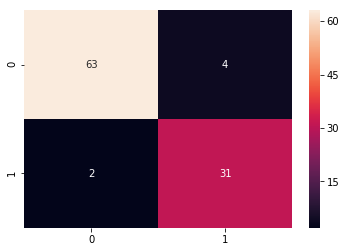

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, y_rf_pred), annot=True, fmt='d')

# サンプリングをしなおして不均衡を薄める
# ランダムフォレスト
# class_weightを入れて不均衡を薄める
# y_predとy_testを見比べて特定して原因を考える

In [55]:
# Cross Validation in X_train

from sklearn.model_selection import cross_val_score
# 交差検証
scores = cross_val_score(clf_rf, X_train, y_train, cv=10)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.97560976 0.92682927 1.         1.         0.8974359  0.94871795
 0.94871795 0.94871795 0.94871795 0.94871795]
Average score: 0.9543464665415884


In [56]:
# Cross Validation in X_test

from sklearn.model_selection import cross_val_score
# rf_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=10, max_features='auto', max_leaf_nodes=20,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
#             oob_score=False, random_state=0, verbose=0, warm_start=False)

# 交差検証
scores = cross_val_score(clf_rf, X_test, y_test, cv=10)
# 各分割におけるスコア
print('Cross-Validation scores: {}'.format(scores))
# スコアの平均値
import numpy as np
print('Average score: {}'.format(np.mean(scores)))

Cross-Validation scores: [0.90909091 0.90909091 0.90909091 1.         0.9        0.8
 0.9        0.88888889 1.         0.88888889]
Average score: 0.9105050505050507


In [57]:
# 回帰分析で有意を確認する。

#　変数を選ぶ
df = Data_train[["wl", "elected_count", "incumbent", "3news_avg", "hereditary", 
                 "party_local_advantage", "party_HR_advantage", "age", "female", "newcomer"]]

# 見てみる
df.info()

# 説明変数と被説明変数を設定する
y = df["wl"]
X = df.drop("wl", axis=1)

# ライブラリのインポート
import statsmodels.formula.api as sm

# モデル作成
model = sm.Logit(y, X)
result = model.fit()

# 分析結果を見る
result.summary()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 224
Data columns (total 10 columns):
wl                       496 non-null int64
elected_count            496 non-null int64
incumbent                496 non-null int64
3news_avg                496 non-null float64
hereditary               496 non-null int64
party_local_advantage    496 non-null float64
party_HR_advantage       496 non-null float64
age                      496 non-null int64
female                   496 non-null int64
newcomer                 496 non-null int64
dtypes: float64(3), int64(7)
memory usage: 42.6 KB
Optimization terminated successfully.
         Current function value: 0.099221
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     wl   No. Observations:                  496
Model:                          Logit   Df Residuals:                      487
Method:                           MLE   Df Model:                            8
Date:                Sat, 20 Jul 2019   Pseudo R-squ.:                  0.8363
Time:                        21:35:43   Log-Likelihood:                -49.214
converged:                       True   LL-Null:                       -300.58
                                        LLR p-value:                1.826e-103
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
elected_count            -1.4991      0.659     -2.273      0.023      -2.792      -0.207
incumbent                -1.6650      1.158     -1.438      0.151      -3.935       0.605
3news_avg                12.7656      1.895      6.737      0.000       9.052      16.479
hereditary                3.4637      1.524      2.273      0.023       0.477       6.450
party_local_advantage     0.0023      0.025      0.091      0.928      -0.047       0.051
party_HR_advantage        0.0268      0.028      0.953      0.340      -0.028       0.082
age                      -0.0467      0.023     -2.042      0.041      -0.091      -0.002
female                   -0.3697      0.583     -0.635      0.526      -1.511       0.772
newcomer                 -4.6100      1.241     -3.716      0.000      -7.042      -2.178
=========================================================================================
"""

# 2019年　予測の実行

In [58]:
# データのインポート
Data2019 = pd.read_pickle("Data2019.pickle")

In [59]:
Data_test = Data2019[["elected_count", "incumbent", "3news_avg", "female", "hereditary", "ruling_weather",
                 "party_local_advantage", "party_HR_advantage", "age", "newcomer"]]

In [60]:
df2_X = Data_test

In [61]:
Data2019

,district,num,candidate_J,age,party,status,elected_count,ldp,kom,jcp,ishin,dpj,syamin,kokumin,incumbent,newcomer,councillors_senkyoku,magnitude,3news_avg,asahi,nikkei,yomiuri,female,scandal,local_ldp_rate,local_dpj_rate,local_jcp_rate,local_kom_rate,local_syamin_rate,local_ishin_rate,ldp_local_rate,dpj_local_rate,jcp_local_rate,kom_local_rate,syamin_local_rate,ishin_local_rate,party_local_advantage,HR_ldp_rate,HR_dpj_rate,HR_kom_rate,HR_jcp_rate,HR_syamin_rate,HR_ishin_rate,ldp_HR_rate,dpj_HR_rate,jcp_HR_rate,kom_HR_rate,syamin_HR_rate,ishin_HR_rate,party_HR_advantage,ruling,local_ruling_rate,ruling_local_rate,ruling_vs,ruling_HR_vs,okinawa,ruling_okinawa,hereditary,Unnamed: 0,weather,ruling_weather
0,北海道,0,森山佳則もりやまよしのり,52,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
1,北海道,1,高橋はるみたかはしはるみ,65,自民,新,0,1,0,0,0,0,0,0,0,1,0,3,1.000000,1.0,1.0,1.0,1,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,46.534653,0.0,0.000000,0.000000,0.0,0.000000,46.534653,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,44.186137,0.000000,0.000000,0.000000,0.000000,0.000000,44.186137,1,54.455446,0.544554,47.780968,0.477810,0,0,0,1,0,0
2,北海道,2,畠山和也はたやまかずや,47,共産,新,0,0,0,1,0,0,0,0,0,1,0,3,0.166667,0.0,0.0,0.5,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,3.960396,0.000000,0.0,0.000000,3.960396,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,5.932484,0.000000,0.000000,0.000000,5.932484,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
3,北海道,3,岩瀬清次いわせせいじ,66,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
4,北海道,4,岩本剛人いわもとつよひと,54,自民,新,0,1,0,0,0,0,0,0,0,1,0,3,0.833333,1.0,1.0,0.5,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,46.534653,0.0,0.000000,0.000000,0.0,0.000000,46.534653,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,44.186137,0.000000,0.000000,0.000000,0.000000,0.000000,44.186137,1,54.455446,0.544554,47.780968,0.477810,0,0,0,1,0,0
5,北海道,5,勝部賢志かつべけんじ,59,立憲,新,0,0,0,0,0,1,0,0,0,1,0,3,1.000000,1.0,1.0,1.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,31.128278,0.000000,0.000000,0.000000,0.000000,31.128278,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
6,北海道,6,中村治なかむらおさむ,66,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
7,北海道,7,原谷那美はらやなみ,35,国民,新,0,0,0,0,0,0,0,1,0,1,0,3,0.000000,0.0,0.0,0.0,1,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
8,北海道,8,山本貴平やまもとたかひら,44,諸派,新,0,0,0,0,0,0,0,0,0,1,0,3,0.000000,0.0,0.0,0.0,0,0,46.534653,0.000000,3.960396,7.920792,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,44.186137,31.128278,3.594831,5.932484,0.000000,0.803791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,54.455446,0.000000,47.780968,0.000000,0,0,0,1,0,0
9,青森,9,小山日奈子こやまひなこ,53,諸派,新,0,0,0,0,0,0,0,0,0,1,0,1,0.000000,0.0,0.0,0.0,1,0,60

In [62]:
# ランダムフォレストによる予測
rf_prob = clf_rf.predict_proba(df2_X) # 予測確率

In [63]:
# ランダムフォレストの予測確率
rf_prob

array([[0.99464504, 0.00535496],
       [0.07840844, 0.92159156],
       [0.99543853, 0.00456147],
       [0.99402503, 0.00597497],
       [0.01356277, 0.98643723],
       [0.08909726, 0.91090274],
       [0.99402503, 0.00597497],
       [0.99129748, 0.00870252],
       [0.99464504, 0.00535496],
       [0.9930537 , 0.0069463 ],
       [0.00539955, 0.99460045],
       [0.99491861, 0.00508139],
       [0.74220041, 0.25779959],
       [0.38161876, 0.61838124],
       [0.99556903, 0.00443097],
       [0.99556903, 0.00443097],
       [0.378414  , 0.621586  ],
       [0.52965032, 0.47034968],
       [0.81871157, 0.18128843],
       [0.3090898 , 0.6909102 ],
       [0.99464504, 0.00535496],
       [0.24799164, 0.75200836],
       [0.7152524 , 0.2847476 ],
       [0.99362301, 0.00637699],
       [0.04554038, 0.95445962],
       [0.9930537 , 0.0069463 ],
       [0.99224798, 0.00775202],
       [0.99556903, 0.00443097],
       [0.99402503, 0.00597497],
       [0.20177291, 0.79822709],
       [0.

In [64]:
rf_prob = pd.DataFrame(rf_prob)
rf_prob = rf_prob.rename({0: "lose_rate", 1: "win_rate"}, axis=1)

In [65]:
# 横に連結する
Prediction = pd.concat([Data2019, rf_prob], axis=1)

# 提出用ファイルの作成

In [66]:
Prediction["win_rate"].value_counts()

0.005975    24
0.005355    22
0.006377    13
0.006305    12
0.005081     9
0.004431     9
0.007752     7
0.007870     4
0.007597     3
0.006946     3
0.008487     3
0.008703     2
0.008490     2
0.814466     2
0.007536     2
0.013865     2
0.992952     2
0.995162     1
0.801800     1
0.470350     1
0.752008     1
0.889698     1
0.952447     1
0.014961     1
0.010825     1
0.803161     1
0.008111     1
0.981165     1
0.983882     1
0.941144     1
0.004452     1
0.871268     1
0.993200     1
0.994511     1
0.878513     1
0.910903     1
0.994488     1
0.004561     1
0.009141     1
0.632637     1
0.618381     1
0.848604     1
0.904457     1
0.112215     1
0.992635     1
0.262219     1
0.984359     1
0.873285     1
0.797004     1
0.741628     1
0.994600     1
0.921592     1
0.900813     1
0.735270     1
0.995397     1
0.933704     1
0.255034     1
0.891268     1
0.991616     1
0.284748     1
0.984449     1
0.798227     1
0.880925     1
0.950351     1
0.983855     1
0.072228     1
0.639188  

In [67]:
prefecture  = Prediction['district'].unique()
prefecture

array(['北海道', '青森', '岩手', '宮城', '秋田', '山形', '福島', '茨城', '栃木', '群馬', '埼玉',
       '千葉', '東京', '神奈川', '新潟', '富山', '石川', '福井', '山梨', '長野', '岐阜', '静岡',
       '愛知', '三重', '滋賀', '京都', '大阪', '兵庫', '奈良', '和歌山', '鳥取・島根', '岡山',
       '広島', '山口', '徳島・高知', '香川', '愛媛', '福岡', '佐賀', '長崎', '熊本', '大分',
       '宮崎', '鹿児島', '沖縄'], dtype=object)

In [68]:
Prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 63 columns):
district                 215 non-null object
num                      215 non-null int64
candidate_J              215 non-null object
age                      215 non-null int64
party                    215 non-null object
status                   215 non-null object
elected_count            215 non-null int64
ldp                      215 non-null int64
kom                      215 non-null int64
jcp                      215 non-null int64
ishin                    215 non-null int64
dpj                      215 non-null int64
syamin                   215 non-null int64
kokumin                  215 non-null int64
incumbent                215 non-null int64
newcomer                 215 non-null int64
councillors_senkyoku     215 non-null int64
magnitude                215 non-null int64
3news_avg                215 non-null float64
asahi                    215 non-null float64
nikkei 

In [69]:
Prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 63 columns):
district                 215 non-null object
num                      215 non-null int64
candidate_J              215 non-null object
age                      215 non-null int64
party                    215 non-null object
status                   215 non-null object
elected_count            215 non-null int64
ldp                      215 non-null int64
kom                      215 non-null int64
jcp                      215 non-null int64
ishin                    215 non-null int64
dpj                      215 non-null int64
syamin                   215 non-null int64
kokumin                  215 non-null int64
incumbent                215 non-null int64
newcomer                 215 non-null int64
councillors_senkyoku     215 non-null int64
magnitude                215 non-null int64
3news_avg                215 non-null float64
asahi                    215 non-null float64
nikkei 

In [70]:
# Prediction = Prediction.assign(outcome = 0)

# for i in prefecture:
#     temp =  Prediction[Prediction.district ==  i]
#     temp = temp.sort_values(by='win_rate', ascending=False)
#     magnitude_of_temp = temp.iloc[1,[1]].values
            
#     count = 0
#     for index, row in temp.iterrows():
#         num = temp['num'][index] 
#         if count < magnitude_of_temp[0]:
#             Prediction['outcome'].where(Prediction['num'] != num, 1, inplace=True)
#         count = count +1
    
# Prediction = Prediction.sort_values("num")

In [71]:
Prediction = Prediction.assign(outcome = 0)

for i in prefecture:
    temp =  Prediction[Prediction.district ==  i]
    temp = temp.sort_values(by='win_rate', ascending=False)
    magnitude_of_temp = temp["magnitude"]
    magnitude_of_temp =  magnitude_of_temp.iloc[1]
            
    count = 0
    for index, row in temp.iterrows():
        num = temp['num'][index] 
        if count < magnitude_of_temp:
            Prediction['outcome'].where(Prediction['num'] != num, 1, inplace=True)
        count = count +1
Prediction = Prediction.sort_values("num")

In [72]:
Prediction_submit = Prediction[["num", "outcome"]]

In [73]:
submit = pd.read_csv("candidates_default.csv")
submit["outcome"] = Prediction_submit["outcome"]

In [74]:
# 74になっているべき
submit["outcome"].sum()

74

In [75]:
submit.to_csv("candidates.csv", index=False)

http://dswaseda.appspot.com/login

In [76]:
Prediction[["win_rate", "3news_avg"]].corr()

,win_rate,3news_avg
win_rate,1.000000,0.966659
3news_avg,0.966659,1.000000


In [77]:
display('自民党候補者:{}'.format(len(Prediction[Prediction.ldp==1])))
display('自民党当選者:{}'.format(len(Prediction[(Prediction.ldp==1)&(Prediction.outcome==1)])))
display('公明党候補者:{}'.format(len(Prediction[Prediction.kom==1])))
display('公明党当選者:{}'.format(len(Prediction[(Prediction.kom==1)&(Prediction.outcome==1)])))
display('立憲候補者:{}'.format(len(Prediction[Prediction.dpj==1])))
display('立憲当選者:{}'.format(len(Prediction[(Prediction.dpj==1)&(Prediction.outcome==1)])))
display('国民候補者:{}'.format(len(Prediction[Prediction.kokumin==1])))
display('国民当選者:{}'.format(len(Prediction[(Prediction.kokumin==1)&(Prediction.outcome==1)])))
display('共産候補者:{}'.format(len(Prediction[Prediction.jcp==1])))
display('共産当選者:{}'.format(len(Prediction[(Prediction.jcp==1)&(Prediction.outcome==1)])))
display('維新候補者:{}'.format(len(Prediction[Prediction.ishin==1])))
display('維新当選者:{}'.format(len(Prediction[(Prediction.ishin==1)&(Prediction.outcome==1)])))
display('社民候補者:{}'.format(len(Prediction[Prediction.syamin==1])))
display('社民当選者:{}'.format(len(Prediction[(Prediction.syamin==1)&(Prediction.outcome==1)])))

'自民党候補者:49'

'自民党当選者:45'

'公明党候補者:7'

'公明党当選者:7'

'立憲候補者:20'

'立憲当選者:10'

'国民候補者:14'

'国民当選者:3'

'共産候補者:14'

'共産当選者:3'

'維新候補者:8'

'維新当選者:3'

'社民候補者:3'

'社民当選者:0'